In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
bone_data <- read_csv("data/boneMarrow.csv")
head(bone_data)
colnames(bone_data)

Rows: 187 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): RecipientABO, RecipientRh, ABOmatch, CMVstatus, DonorCMV, Recipien...
dbl (25): id, Recipientgender, Stemcellsource, Donorage, Donorage35, IIIV, G...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,⋯,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,22.83014,0,1,0,1,1,1,⋯,1,7.20,1.33876,5.38,35,19,51,32,999,0
2,1,0,23.34247,0,1,0,-1,-1,1,⋯,1,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
3,1,0,26.39452,0,1,0,-1,-1,1,⋯,1,7.94,19.01323,0.42,23.4,23,20,1000000,435,1
4,0,0,39.68493,1,1,0,1,2,1,⋯,?,4.25,29.481647,0.14,50,23,29,19,53,1
5,0,1,33.35890,0,0,0,1,2,0,⋯,1,51.85,3.972255,13.05,9,14,14,1000000,2043,0
6,1,0,27.39178,0,0,0,2,0,1,⋯,1,3.27,8.412758,0.39,40,16,70,1000000,2800,0


[1] "id"                   "Recipientgender"      "Stemcellsource"      
 [4] "Donorage"             "Donorage35"           "IIIV"                
 [7] "Gendermatch"          "DonorABO"             "RecipientABO"        
[10] "RecipientRh"          "ABOmatch"             "CMVstatus"           
[13] "DonorCMV"             "RecipientCMV"         "Disease"             
[16] "Riskgroup"            "Txpostrelapse"        "Diseasegroup"        
[19] "HLAmatch"             "HLAmismatch"          "Antigen"             
[22] "Alel"                 "HLAgrI"               "Recipientage"        
[25] "Recipientage10"       "Recipientageint"      "Relapse"             
[28] "aGvHDIIIIV"           "extcGvHD"             "CD34kgx10d6"         
[31] "CD3dCD34"             "CD3dkgx10d8"          "Rbodymass"           
[34] "ANCrecovery"          "PLTrecovery"          "time_to_aGvHD_III_IV"
[37] "survival_time"        "survival_status"

In [4]:
bone_selected <- bone_data |>
select(Donorage, Recipientage, DonorABO, RecipientABO, Relapse, survival_time, survival_status)|>
mutate(survival_status = as_factor(survival_status))
bone_selected

Donorage,Recipientage,DonorABO,RecipientABO,Relapse,survival_time,survival_status
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
22.83014,9.6,1,1,0,999,0
23.34247,4.0,-1,-1,1,163,1
26.39452,6.6,-1,-1,1,435,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
27.34794,10.4,1,-1,0,1895,0
27.78082,8.0,1,0,0,382,1
55.55342,9.5,1,2,0,1109,0


In [5]:
survival_summarize <- bone_selected |>
group_by(survival_status) |>
summarize(count=n())
survival_summarize

set.seed(1)
bone_split <- initial_split(bone_selected, prop=0.7, strata=survival_status)
bone_train <- training(bone_split)
bone_test <- testing(bone_split)
train_summarize <- bone_train |>
group_by(survival_status) |>
summarize(count=n())
train_summarize

survival_status,count
<fct>,<int>
0,102
1,85


survival_status,count
<fct>,<int>
0,71
1,59


# PART1-AGE

In [6]:
bone_age <- bone_train |>
select(Donorage,Recipientage,Relapse,survival_time,survival_status)|>
mutate(age_diff = Donorage-Recipientage)|>
mutate(DonorAgeGroup = cut(Donorage, breaks = c(0,5,10,15,20,25,30,35,100),
              labels=c("<5","5-10","10-15","15-20","20-25","25-30","30-35","35+")))|>
mutate(RecipientAgeGroup = cut(Recipientage, breaks = c(0,5,10,15,20,25,30,35,100),
              labels=c("<5","5-10","10-15","15-20","20-25","25-30","30-35","35+")))
bone_age

Donorage,Recipientage,Relapse,survival_time,survival_status,age_diff,DonorAgeGroup,RecipientAgeGroup
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
22.83014,9.6,0,999,0,13.23014,20-25,5-10
33.35890,1.3,0,2043,0,32.05890,30-35,<5
29.73151,1.9,0,599,0,27.83151,25-30,<5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
37.57534,12.9,1,385,1,24.67534,35+,10-15
22.89589,13.9,0,634,1,8.99589,20-25,10-15
27.78082,8.0,0,382,1,19.78082,25-30,5-10


In [7]:
Recipient_summarize <- bone_age |>
group_by(RecipientAgeGroup)|>
summarize(RecipientAgeCount=n())|>
rename(age=RecipientAgeGroup)
Recipient_summarize 

Donor_summarize <- bone_age |>
group_by(DonorAgeGroup)|>
summarize(DonorAgeCount=n())|>
rename(age=DonorAgeGroup)
Donor_summarize 

age,RecipientAgeCount
<fct>,<int>
<5,35
5-10,31
10-15,35
15-20,27
20-25,2


age,DonorAgeCount
<fct>,<int>
15-20,3
20-25,27
25-30,13
30-35,27
35+,60


In [8]:
options(tibble.print_max = 8) # to show all the rows.
age_summarize <- full_join(x=Donor_summarize,y=Recipient_summarize,by="age")|>
arrange(by=age)|>
rename(donor_age = DonorAgeCount,recipient_age = RecipientAgeCount)
print.data.frame(age_summarize)

    age donor_age recipient_age
1    <5        NA            35
2  5-10        NA            31
3 10-15        NA            35
4 15-20         3            27
5 20-25        27             2
6 25-30        13            NA
7 30-35        27            NA
8   35+        60            NA


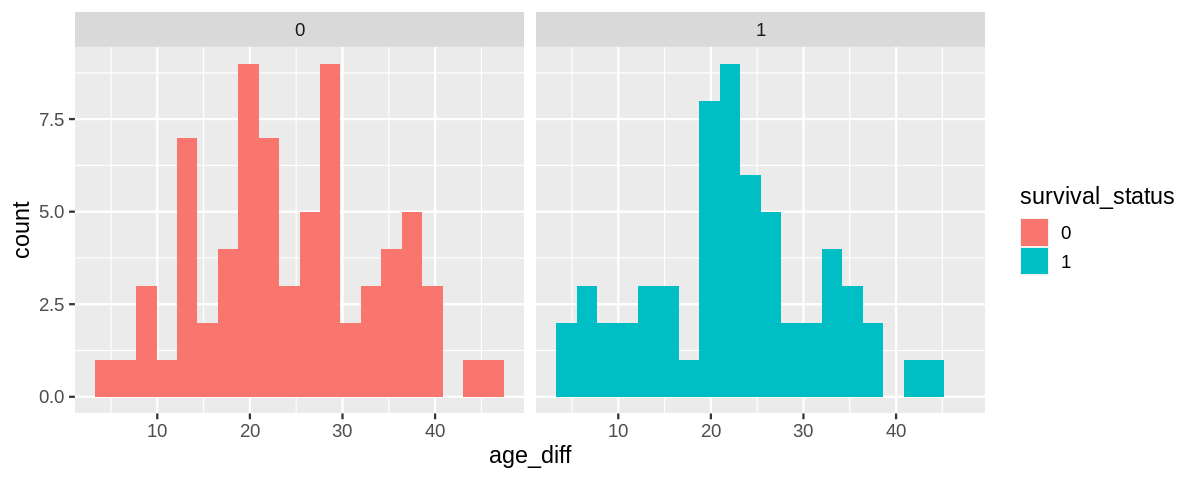

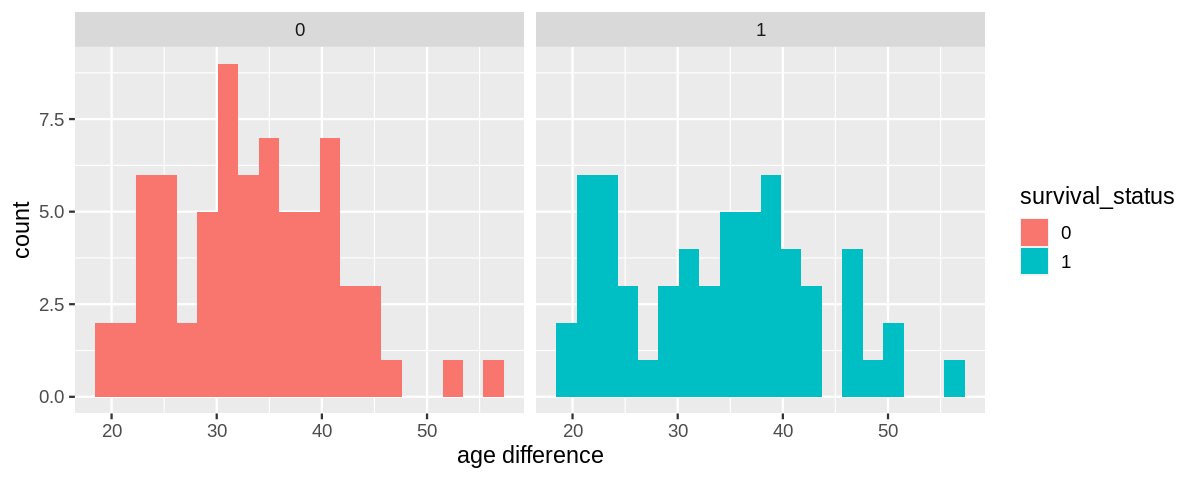

In [62]:
options(repr.plot.width=10,repr.plot.height=4)
age_diff_plot <- bone_age |>
# revalue(str, c("0"="death", "1"="survival"))
# mapvalues(from=c("0","1"), 
#           to=c("death","survival"))

ggplot(aes(x=age_diff,fill=survival_status))+
geom_histogram(bins=20)+
facet_grid(cols=vars(survival_status))
age_diff_plot

age_plot <- bone_age |>
ggplot(aes(x=Donorage,fill=survival_status))+
geom_histogram(bins=20)+
facet_grid(cols=vars(survival_status))+
labs(x="age difference", y = "count",color= "survival status")
age_plot

# part 2 - blood

In [18]:
# 'DonorABO''RecipientABO'
blood_summarize <- bone_train |>
select(DonorABO, survival_status)|>
group_by(DonorABO,survival_status) |>
summarize(count=n())
blood_summarize

`summarise()` has grouped output by 'DonorABO'. You can override using the
`.groups` argument.


DonorABO,survival_status,count
<dbl>,<fct>,<int>
-1,0,12
-1,1,7
0,0,26
⋮,⋮,⋮
1,1,28
2,0,7
2,1,2


In [54]:
options(repr.plot.width=6,repr.plot.height=4)
blood_summarize2 <- bone_train |>
select(RecipientABO, DonorABO, survival_status) |>
  mutate(RecipientABO = case_when(
      RecipientABO == -1 ~ 'B',
      RecipientABO == 1 ~ 'A',
      RecipientABO == 0 ~ 'O',
      RecipientABO == 2 ~ 'AB')) |>
mutate(DonorABO = case_when(
      DonorABO == -1 ~ 'B',
      DonorABO == 1 ~ 'A',
      DonorABO == 0 ~ 'O',
      DonorABO == 2 ~ 'AB'))

Donor_summarize <- blood_summarize2 |>
group_by(DonorABO, survival_status)|>
summarize(count=n())|>
pivot_wider(names_from=survival_status,
            values_from=count) |>
rename("survive" = "1", "death" = "0")|>
mutate(survival_rate = survive/(death+survive))
Donor_summarize

`summarise()` has grouped output by 'DonorABO'. You can override using the
`.groups` argument.


DonorABO,death,survive,survival_rate
<chr>,<int>,<int>,<dbl>
A,26,28,0.5185185
AB,7,2,0.2222222
B,12,7,0.3684211
O,26,22,0.4583333


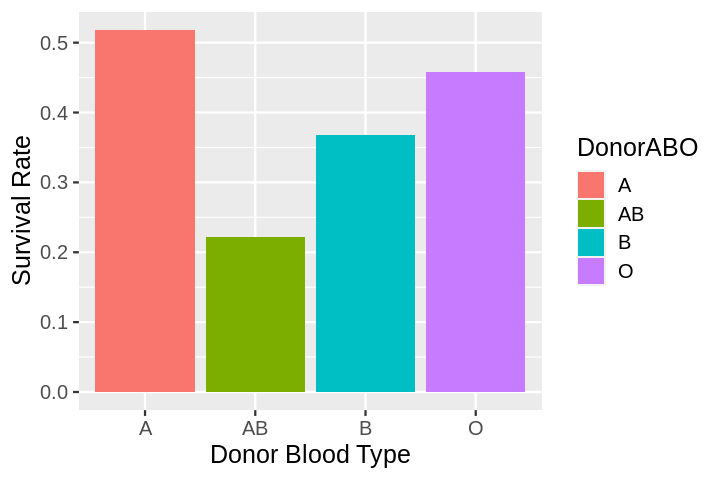

In [58]:
Donor_plot <- Donor_summarize |>
ggplot(aes(x = as.factor(DonorABO), y = survival_rate, fill=DonorABO))+
geom_bar(stat = "identity")+
labs(x="Donor Blood Type", y = "Survival Rate")+
theme(text = element_text(size=15))
Donor_plot

In [35]:
Recipient_summarize <- blood_summarize2 |>
group_by(RecipientABO, survival_status)|>
summarize(count=n())|>
pivot_wider(names_from=survival_status,
            values_from=count) |>
rename("survive" = "1", "death" = "0")|>
mutate(survival_rate = survive/(death+survive))|>
filter(RecipientABO != "NA")
Recipient_summarize

`summarise()` has grouped output by 'RecipientABO'. You can override using the
`.groups` argument.


RecipientABO,death,survive,survival_rate
<chr>,<int>,<int>,<dbl>
A,28,26,0.4814815
AB,5,2,0.2857143
B,20,15,0.4285714
O,18,15,0.4545455


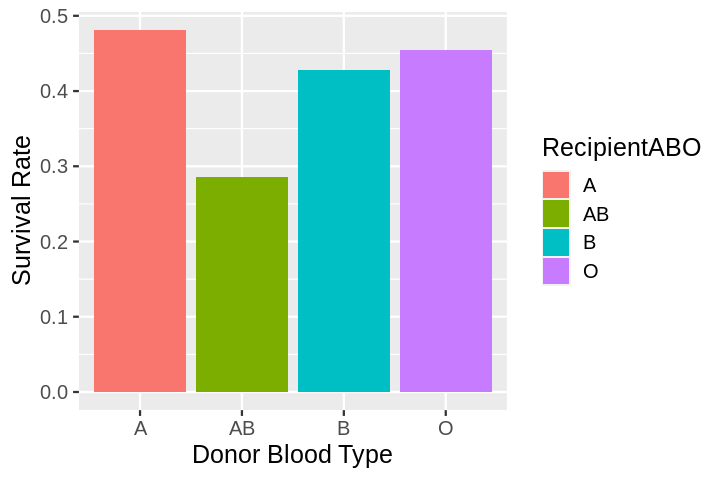

In [61]:
Recipient_plot <- Recipient_summarize |>
ggplot(aes(x = as.factor(RecipientABO), y = survival_rate, fill=RecipientABO))+
geom_bar(stat = "identity")+
labs(x="Donor Blood Type", y = "Survival Rate")+
theme(text = element_text(size=15))
Recipient_plot

# part 3 - All visualization summarized